# MRI data analysis with `cloudknot`

This example demonstrates analysis of MRI data using software that depends on the scipy stack, 
as well as on smaller open-source software projects

The data for each participant in the study is non-trivial in size (about 140 MB per subject),
and complexity (4D arrays representing MRI measurements in every location in the brain with 
diffusion gradients in multiple directions). The analysis requires non-trivial computations 
(e.g., fitting a linear model over directions in every spatial location). 

The data we will use is publicly accessible through a URL pointing to the Stanford Data Repository
We will pull down each participant's data using a URL that the function constructs based on its 
input.

In [1]:
import cloudknot as ck

In [2]:
def calculate_fa(sub):
    """ 
    Process MRI data from a single subject. 
    
    Saves results to S3.

    Parameters
    ----------

    sub : str
        The ID string forone of the subjects in this data-set. 
        One of  {'SUB1', 'SUB2', 'SUB3', 'SUB4', 'SUB5', 'SUB6'}
    
    """
    import os
    import os.path as op
    import requests

    # Helper function to download files and save them:
    def download_file(url, fname):
        if not op.exists(fname):
            r = requests.get(url)
            with open(fname , 'wb') as fd:
                for chunk in r.iter_content(chunk_size=128):
                    fd.write(chunk)
    
    print("Creating folder structure for data")
    base_folder = op.join(op.expanduser('~'), 'data')
    if not op.exists(base_folder):
        os.mkdir(base_folder)
        os.mkdir(op.join(base_folder, 'sub-01'))
        os.mkdir(op.join(base_folder, 'sub-01', 'sess-01'))
        anat_folder = op.join(base_folder, 'sub-01', 'sess-01', 'anat')
        os.mkdir(anat_folder)
        dwi_folder = op.join(base_folder, 'sub-01', 'sess-01', 'dwi')
        os.mkdir(dwi_folder)

    print("Downloading data from the Stanford Data Repository")
    data_url = 'https://stacks.stanford.edu/file/druid:rt034xr8593/'
    sub_data = data_url + sub
    fbvals_url = sub_data + "_1.bvals"
    fbvecs_url = sub_data + "_1.bvecs"
    fnii_url = sub_data + "_1.nii.gz"
    
    download_file(fnii_url, op.join(dwi_folder, 'dwi.nii.gz'))
    download_file(fbvals_url, op.join(dwi_folder, 'dwi.bvals'))
    download_file(fbvecs_url, op.join(dwi_folder, 'dwi.bvecs'))

    print("Creating AFQ object")   
    from AFQ.api import AFQ
    my_afq = AFQ(preproc_path=base_folder, sub_prefix='sub')
    
    print("Calculating FA")
    fa_file = my_afq.dti_fa[0]

    print("Uploading to S3")
    client = boto3.resource('s3')
    bucket_name = 'escience.washington.edu.public'
    b = client.Bucket(bucket_name)
    b.upload_file(fa_file, '%s_FA.nii.gz' % sub)    
    print("Return FA back to user")
    import nibabel as nib
    fa = nib.load(fa_file).get_data()
    return fa

In [3]:
knot = ck.Knot(name='calculate-fa',
               # With image_github_installs, we can select a fork/branch to install from:
               image_github_installs=("https://github.com/arokem/pyAFQ.git@no-anat"),
               base_image="python:3.7",
               # Or even a specific commit:
               #image_github_installs=("https://github.com/arokem/pyAFQ.git@afd7221"),
               func=calculate_fa, pars_policies=('AmazonS3FullAccess',))

In [4]:
result_futures = knot.map(['SUB1', 'SUB2', 'SUB3', 'SUB4', 'SUB5', 'SUB6'])

In [12]:
knot.view_jobs()

Job ID              Name                        Status   
---------------------------------------------------------
d43dc89b-745e-4b6b-80ab-e53c4438f688        calculate_fa-5              SUCCEEDED
33262a8b-91ec-48f5-ba3a-a95c1a5a21bc        calculate_fa-4              SUCCEEDED
49f4e299-bf36-45b6-a7c8-af0446d64f6e        calculate_fa-2              SUCCEEDED
0314b338-4b3f-4ff9-9b9b-e211cb51f2ae        calculate_fa-3              SUCCEEDED
799d06f5-37fe-460b-802d-ca87b92f3aaf        calculate_fa-0              SUCCEEDED
56fd41c1-6841-4f83-ab9e-08ed36251a94        calculate_fa-1              SUCCEEDED


In [14]:
r0 = result_futures[0]

In [17]:
fa0 = r0.result()

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

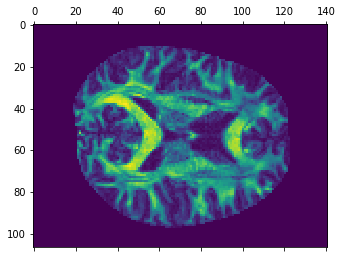

In [20]:
plt.matshow(fa0[:, :, fa0.shape[-1]//2])

In [20]:
#knot.clobber(clobber_pars=True, clobber_repo=True, clobber_image=True)